In [1]:
# Import necessary packages for text processing, graph analysis, and visualization
import os
import glob
import re
import networkx as nx
from collections import Counter
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
# Set the file paths to your data directories and files
discord_data_folder = r'C:\Users\neelb\Desktop\MEDD8925 - Analyzing Data Quantitatively\MEDD8925 Discord Project\Cleaned Discord Data'
urban_dict_file = r'C:\Users\neelb\Desktop\MEDD8925 - Analyzing Data Quantitatively\MEDD8925 Discord Project\urban_dictionary_one_word_slangs.txt'
stopwords_file = r'C:\Users\neelb\Desktop\MEDD8925 - Analyzing Data Quantitatively\MEDD8925 Discord Project\English_stoplist.txt'

In [3]:
# Function to read all text files in a folder (for Discord messages)
def read_all_texts(folder):
    texts = []
    for filepath in glob.glob(os.path.join(folder, '*.txt')):
        with open(filepath, 'r', encoding='utf-8', errors='ignore') as f:
            texts.append(f.read())
    return texts

# Function to read a list of words from a text file (for stopwords or slang)
def read_wordlist(filepath):
    with open(filepath, 'r', encoding='utf-8') as f:
        return set([line.strip().lower() for line in f if line.strip()])

# Load all files
discord_texts = read_all_texts(discord_data_folder)
urban_slangs = read_wordlist(urban_dict_file)
stopwords = read_wordlist(stopwords_file)

# Print summary of loaded data
print(f"Loaded {len(discord_texts)} Discord text files")
print(f"Loaded {len(urban_slangs)} Urban Dictionary slang terms")
print(f"Loaded {len(stopwords)} stopwords")

Loaded 736 Discord text files
Loaded 1540197 Urban Dictionary slang terms
Loaded 142 stopwords


In [4]:
# Simple tokenization: lowercase, remove stopwords, split on word boundaries
def simple_tokenize(text):
    return re.findall(r"\b\w[\w']*\b", text.lower())

# Tokenize all Discord texts and filter out stopwords and very short tokens
all_tokens = []
for text in discord_texts:
    tokens = [t for t in simple_tokenize(text) if t not in stopwords and len(t) > 1]
    all_tokens.extend(tokens)

print("Sample tokens:", all_tokens[:20])

Sample tokens: ['guess', 'need', 'hide', 'gender', 'againn', 'yo', 'monxnhow', 'tf', 'handle', 'period', 'cramps', 'having', 'same', 'thing', 'ofc', 'cramps', 'hug', 'lay', 'warm', 'pad']


In [5]:
# This cell creates a co-occurrence graph (nodes = words, edges = co-occurrence within a sliding window)
WINDOW_SIZE = 4  # How many words in each window

G = nx.Graph()
for i in range(len(all_tokens) - WINDOW_SIZE):
    window = all_tokens[i:i+WINDOW_SIZE]
    for j in range(len(window)):
        for k in range(j+1, len(window)):
            w1, w2 = window[j], window[k]
            if w1 != w2:
                if G.has_edge(w1, w2):
                    G[w1][w2]['weight'] += 1
                else:
                    G.add_edge(w1, w2, weight=1)

print(f"Graph has {G.number_of_nodes()} nodes and {G.number_of_edges()} edges.")

Graph has 3354272 nodes and 83236901 edges.


In [6]:
# Apply PageRank algorithm to find central (important) words in the graph
pagerank_scores = nx.pagerank(G, weight='weight')

# Example: view the top 10 words by centrality (not yet filtered to slang)
top_words = sorted(pagerank_scores.items(), key=lambda x: x[1], reverse=True)[:10]
print("Top 10 most central words (unfiltered):")
for word, score in top_words:
    print(f"{word:15} {score:.5f}")

Top 10 most central words (unfiltered):
im              0.00906
like            0.00872
welcome         0.00654
don             0.00470
hi              0.00456
good            0.00440
dont            0.00394
hug             0.00383
ok              0.00369
am              0.00348


In [7]:
# Filter results to show only slang words present in Urban Dictionary list
central_slang = [(word, score) for word, score in pagerank_scores.items() if word in urban_slangs]
central_slang.sort(key=lambda x: x[1], reverse=True)

# Print top 25 most central slang words with their PageRank scores
print("\nTop 25 central slang terms used on Discord (for parents/teachers):\n")
for word, score in central_slang[:25]:
    print(f"{word:15} {score:.5f}")


Top 25 central slang terms used on Discord (for parents/teachers):

like            0.00872
welcome         0.00654
don             0.00470
hi              0.00456
good            0.00440
hug             0.00383
am              0.00348
know            0.00345
ur              0.00322
want            0.00278
now             0.00275
wait            0.00253
hey             0.00251
pat             0.00230
see             0.00229
need            0.00225
think           0.00225
say             0.00216
love            0.00212
mean            0.00212
wanna           0.00202
hello           0.00201
name            0.00201
time            0.00189
server          0.00183


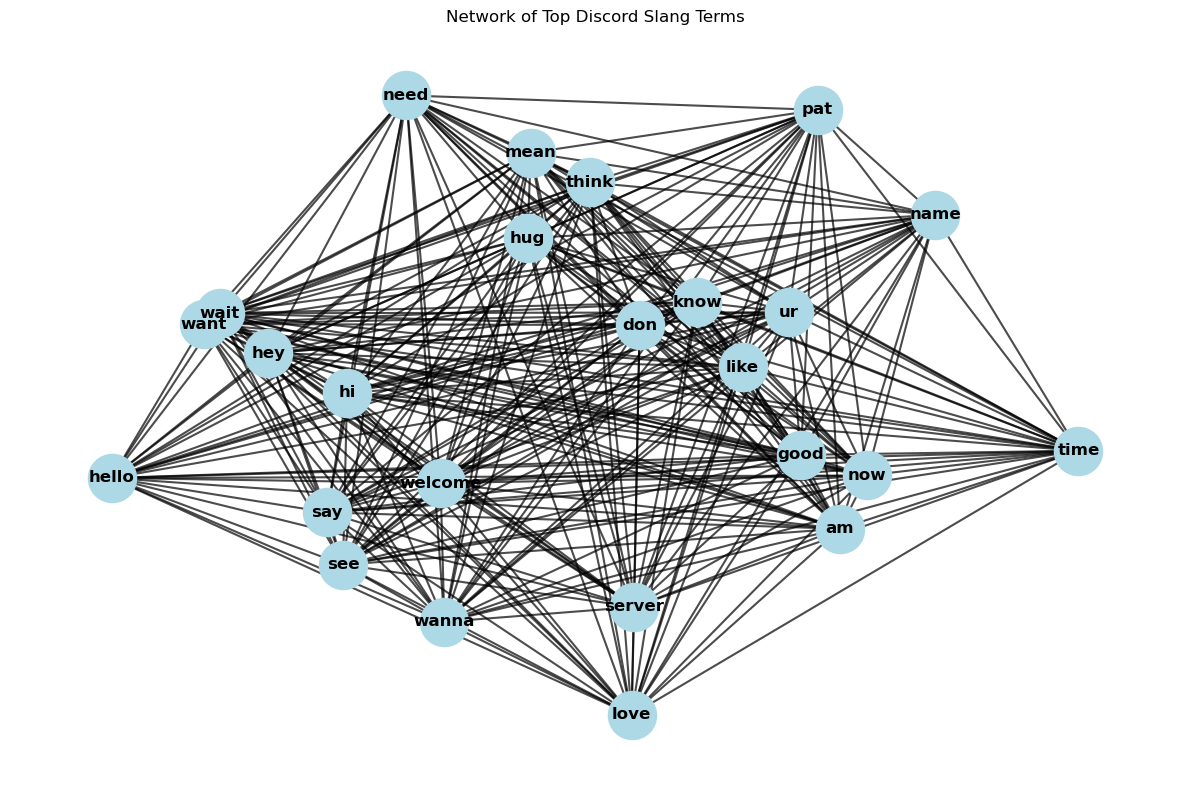

In [8]:
# Visualize the network of the top 25 slang words (shows which are closely connected in context)
top_n = 25
top_words = [w for w, _ in central_slang[:top_n]]
subgraph = G.subgraph(top_words)

plt.figure(figsize=(12, 8))
pos = nx.spring_layout(subgraph, k=0.5, seed=42)
nx.draw_networkx_nodes(subgraph, pos, node_color='lightblue', node_size=1200)
nx.draw_networkx_edges(subgraph, pos, width=1.5, alpha=0.7)
nx.draw_networkx_labels(subgraph, pos, font_size=12, font_weight='bold')
plt.title("Network of Top Discord Slang Terms")
plt.axis('off')
plt.tight_layout()
plt.show()